# Machine Learning Course Project: Partially Supervised Feature Selection with Regularized Linear Models

### Designed by Diego Fuentes Palacios
#### Mail: diegofupa@gmail.com

In [1]:
#Import all the packages we are going o need
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

## Project Tasks

One of the main problems we might face when dealing with biological information is the curse of dimensionality that in combination with the relatively low number of samples makes the task of feature selection (FS) crucial in prediction models development.
FS can be applied both for supervised and unsupervised learning, but it is the former the one which has experienced a higher development in the recent years. The goal for FS methods is principally to return a subset of features that sufficiently represent the complexity within the dataset.

Feature selection techniques are critically used:

* To **avoid the overfitting of the model** and thus improve its **performance**
* To provide **faster and less computationally expensive** models.
* To provide a better **understanding of the underlying processes** that generated the data 

However, this advantages come at a certain cost as it is now required instead of just optimize the model's parameter; to find the optimum model's parameters for an optimum features subset. This provides a new dimension in the model hypothesis space that adds a new layer of complexity to be tackled head-on.

### Feature selection taxonomy
Feature selection techniques differ and are classified from each other in the way they incorporate this search of feature subsets in the model selection (**Table 1**)

**Table 1.**
*A taxonomy of feature selection techniques and some of its characteristics and highlights. [1]*
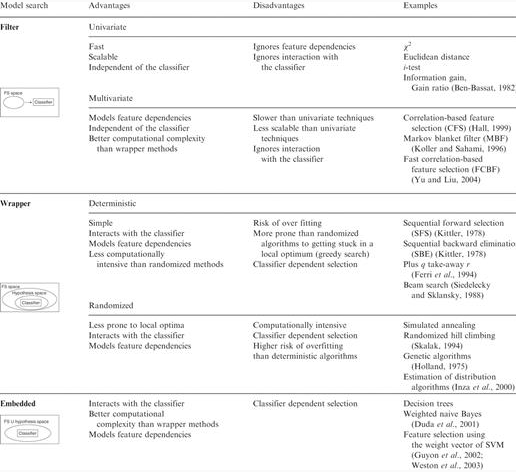

* **Filter techniques**:  this set of techniques is characterized by the selection of relevant features based only in the data, without paying attention to the ulterior classifier to be used. These are simple methods, easily scalable, fast, and once performed the FS, different classifiers can be used. However, the independence with the classifier can be a problem as the subset of features selected can work quite well with a certain model but worse with others. Filter methods include univariate (independent features) and multivariate (feature dependencies) methods.

    
    
* **Wrapper techniques**: these techniques consider a specific classifier, and make a feature subset selection trying to optimize the result with that given classifier. For subset exploration both deterministic and randomized search algorithms can be used. These methods, alike multivariate filter techniques, have the ability of considering feature dependencies. The interaction with the classifier constitutes also an advantage. The main drawback is the high computational requirements for the exploration of possible feature subsets.


* **Embedded techniques**: in these methods the FS is part of the model construction. One clear example is the LASSO method that penalizes regression coefficients that are less useful for fitting a linear model using the $\ell_1$ norm. Those features shrinked to 0 are discarded. These methods have the advantage of the interaction with a certain model, while they are much less computationally demanding than wrapper methods.

In this project we are going to work with $\ell_2$-AROM (Approximation of the zero-norm Minimization) and PS-$\ell_2$-AROM.
$\ell_2$-AROM approximately minimizes the $\ell_0$ norm by iteratively solving several optimization problems regularized by the $\ell_2$ norm. As this method is based around training several times a Support Vector Machine (SVM) over the re-scaled versions of the training set, it can be concluded that it is an **embeded feature selection method**[3]. Provided PS-$\ell_2$ algorithm is based on $\ell_2$-AROM, it is also an embeded FS technique.
    
    
### Feature selection applications and implementations in bioinformatics
FS has applications in several biological problems, like sequence analysis, microarray and mass
spectra analysis

1) **Sequence analysis**: In the context of FS two types of problems tend to be described: content analysis and signal analysis. 


  - *Content analysis*: it focuses on the prediction of sequences coding for proteins, that use different Markov model derived techniques, and also tries to predict protein function from sequence, using combinations of techniques like genetic algorithms and the Gamma test for scoring.


 - *Signal analysis*: it focuses on finding discrete motifs: binding sites, translation initiation sites or splice sites. Several algorithms are used in this domain, like regression approaches and support vector machines (SVM).
 
2) **Microarray analysis**: FS has become crucial in microarray analysis, provided the large number of dimensions (tens of thousands of genes) and the lack of samples. Two paradigms: univariate and multivariate filters:

  - *Univariate filters*: probabily the most used due to their efficiency and simplicity. Can be divided into parametric and model-free methods. Although parametric approaches, with Gaussian assumptions are very frequent, non-parametric methods are usually preferred due to the typical uncertainty regarding data distributions. Usually the whole set of samples is considered for the identification of differentially expressed genes but there are also methods able to capture gene alterations within small subsets of samples, which could be determinant for patient-specific level diagnostics.
  
  - *Multivariate filters*: recently are gaining relevance as they consider gene-gene interactions. Applications for filtering, wrapper and embedded techniques have been developed. In the case of wrapper methods, the scoring function has special relevance. The most used include the ROC curve and the optimization of LASSO function.
  
  
3) **Mass spectra analysis**: Similar techniques are being applied to the mass spectra analysis field, where the initial number of features can reach 100000. Combinations of feature extraction and feature selection methods are implemented to reduce the number of features to a range of 300-500.


As it has been broadly discussed above, biological data adolesce from small sample sizes. This can lead to overfitting and imprecision. To control for these problems is important in the first place to have an adequate evaluation criteria (for example: not using training data for evaluation). Another method to perform better approximations consists in using ensemble methods, that combine several FS approaches. This latter methods have proved to perform better than previous ones, even though they require additional computational resources. Finally, FS methods are gaining representation in upcoming fields, like single nucleotide polymorphism (SNP) analysis and biomedical text mining. In the first case, FS techniques try to select subsets of SNPs from which the rest can be derived. Text mining has relevant applications in the biological field for hypothesis discovery, extraction of medical parameters of interest, etc.


In conclusion the problem that high-dimensionality/sample size ratio represents in biodata analysis imposes the need for efficient FS methods that let us build accurate models and avoid overfitting


### $\ell_2$-AROM and the PS-$\ell_2$-AROM implementation

To explain $\ell_2$-AROM we need to briefly explain what AROM (Approximation of the zero-norm Minimization) is: AROM is used to find a hyper-plane w separating the data in two classes in such a way that many of the components of w are zero[2]. That is, if a particular component of w, wj , is zero, the attribute values corresponding to that component are irrelevant for the decision process. This is equivalent to discarding features for prediction. In $\ell_2$-AROM this approximation of the zero-norm minimization is achieved through the $\ell_2$ norm.

$\ell_2$-AROM final algorithm implementation boils down to a linear SVM estimation with iterative rescaling of the inputs. A smooth feature selection occurs during this iterative process since the weight coefficients along some dimensions progressively drop below a provided threshold while other dimensions become more significant[3]. A final ranking on the absolute values of each dimension can be used to obtain a fixed number of features. Finally, it returns a vector with the selected features indices.

#### The PS-$\ell_2$-AROM implementation is presented below:

In [2]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings("ignore")

##
# X is numpy array witht the data (rows are data instances)
# Y is a numpy vector with the class labels (-1 or 1)
# C is the regularization coefficient of the SVM
# threshold is the threshold value to drop features in L2AROM

def variable_ranking(X, Y, z, C = 1, threshold = 1e-10): #we have added the argument of providing a z vector
    """
    """

    # Copy X to modify it later

    final_X = X.copy()

    # Number of attributes

    length = z.shape[0]

    # Array that stores the elimination order, being the higher number the first attribute 
    # that is eliminated and 1 the last one

    elimination_order = np.zeros(length, dtype = int)
    original_feature_indices = np.arange(0, length, dtype = int)
    clf = SVC(kernel = "linear", C = C, random_state = 0)

    iter_without_dropping = 0
    n_removed_features = 0

    while iter_without_dropping < 20 and length > 10:

        # Fit the SVC and compute z

        clf.fit(final_X * np.outer(np.ones(X.shape[ 0 ]), z), Y)
        z *= np.abs(clf.coef_[0]) # In absolute value

        n_features_to_drop = np.sum(z < threshold)
        
        if n_features_to_drop == 0:
            iter_without_dropping += 1
        else:
            iter_without_dropping = 0
            remove_order = np.argsort(z[ z < threshold ])
            elimination_order[ original_feature_indices[ z < threshold ][ remove_order ] ] = \
                np.arange(0, n_features_to_drop) + n_removed_features + 1
            n_removed_features += n_features_to_drop
            length -= n_features_to_drop
        
            # Delete from X, z and original_features the selected attributes 

            final_X = final_X[ :, z >= threshold ]
            original_feature_indices = original_feature_indices[ z >= threshold ]
            z = z[ z >= threshold ]

    # We remove all remaining features

    if length > 0:
            remove_order = np.argsort(z)
            elimination_order[ original_feature_indices[ remove_order ] ] = \
                np.arange(0, length) + n_removed_features + 1

    return np.argsort(-elimination_order)  # So array starts at 0 (python indexing)

**Reproduce the experiments reported in [4]. Note that given a particular selected subset of variables, the classifier employed should be a soft-margin linear SVM with C = 1.**


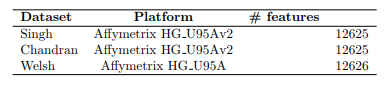



I have first tried to implement the author's pipeline. Additionally I provided my own take on different issues we faced during this project.

<br></br>
## <i><u>First implementation: Author's pipeline -> Feature selection by transfer learning [4]</u></i>

<br></br>
## <i><u>Importing data sets: <font color = "red">Singh<font color = "black">,</font> Chandran<font color = "black">,</font> Welsh</font></u></i>

In [3]:
#We read all the datasets into pandas dataframes
SINGH    = pd.read_csv("data/singh.csv")
CHANDRAN = pd.read_csv("data/chandran.csv")
WELSH  = pd.read_csv("data/welsh.csv")

#Note that welsh has 1 feature more. In order to correct for this issue we are going to drop the first feature
WELSH = WELSH.drop(columns="AFFX.MurIL2_at") #We need to do this for the intercept in multiple transfer

x_chandran = CHANDRAN.values[ :, :-1].astype(np.float)
y_chandran = (CHANDRAN.values[ :, -1] ==1).astype(np.int)
x_singh = SINGH.values[ :, :-1].astype(np.float)
y_singh = (SINGH.values[ :, -1] ==1).astype(np.int)
x_welsh = WELSH.values[ :, :-1].astype(np.float) #because it has one feature more.
y_welsh = (WELSH.values[ :, -1] ==1).astype(np.int)


print(SINGH.shape)
print(x_singh.shape)
print(y_singh.shape)
print(CHANDRAN.shape)
print(x_chandran.shape)
print(y_chandran.shape)
print(WELSH.shape)
print(x_welsh.shape)
print(y_welsh.shape)

(102, 12626)
(102, 12625)
(102,)
(104, 12626)
(104, 12625)
(104,)
(34, 12626)
(34, 12625)
(34,)


<br></br>
## <i><u>Using an <font color ="green">ANOVA</font> feature ranking in order to obtain the z vector</u></i>

"*The vector β used for PS-l2-AROM is set by selecting a signature Ss on Ds with a t-test ranking. The 50 top ranked features define SS, which is a common default signature size for biomarker selection.*" [4]


The t-test with two groups assumes that each group is normally distributed with the same variance (although the means may differ under the alternative hypothesis). That is equivalent to a regression with a dummy variable as the regression allows the mean of each group to differ but not the variance. Hence the residuals (equal to the data with the group means subtracted) have the same distribution --- that is, they are normally distributed with zero mean. Of course a t-test with unequal variances is not equivalent to a one-way ANOVA.

However, it was mentioned in  the article that *"These samples are first normalized to zero median and unit standard deviation."*[4]. Making it possible to select a **one-way ANOVA** as an equivalent statistic. Moreover *"Any standard feature selection method can be used for the initial selection on DS. We recommend in particular the use of a simple univariate technique such as a t-test ranking. It is computationally efficient and this initial selection is not meant to be highly accurate on DS but to guide the detailed selection to be performed eventually on DT"*[4].


Consequently it was used the  *SelectKBest(score_func=f_classif, k = 50)*


<br></br>
## <i><u>Function for getting <font color ="blue">z vector</font>: single transfer based on the paper</u></i>


Here I faced my first major issue with the original's paper assumptions. The basis of my critique is derived from: *"**We assume that the data from all domains share a sufficiently large set of n features and, without loss of generality, that feature index j in DS maps to the same index in DT . The proposed approach simply uses any convenient feature selection on DS to build an initial signature SS**"*

Which was in my honest opinion, quite a strong assumption. So strong, that it was proven factually erroneous when looking at the Welsh dataset. However the assumption was probably based first on practicallity, so while I was thinking ways to bypass this assumption, I decided to perform it first using the author's pipeline and then try to test my take on the matter.

In [4]:
## Function for getting the "z" vector that will be used for PS-l2-AROM algorithm in the case of single transfer
def get_z_vector_single_paper(X_s, y_s, Dt, b=10):
    """X_s is the source data and y_s is the source labels. Dt is the target dataset"""
    
    X_50 = SelectKBest(f_classif, k=50).fit(X_s, y_s).get_support(indices=True) #Select 50 best using ANOVA
    
    #We create the vector Z
    
    z = np.ones(Dt.shape[1]-1)
    z[X_50] = b #We assign a value of 10 to those features found to be best in Ds
    
    return z, len(X_50)    

<br></br>
## <i><u>Function for getting <font color ="blue">z vector</font>: multiple transfer based on the paper</u></i>


In [5]:
## Function for getting the "z" vector that will be used for PS-l2-AROM algorithm in the case of dual transfer

def get_z_vector_multiple_1_paper(X_s1, y_s1, X_s2, y_s2, k1, k2, Dt, b=10):
    """Ds1 is the first source dataset, Ds2 is the second and Dt the target"""
    
    XS1_50 = SelectKBest(f_classif, k=k1).fit(X_s1, y_s1).get_support(indices=True) #Select 50 best using ANOVA
    XS2_50 = SelectKBest(f_classif, k=k2).fit(X_s2, y_s2).get_support(indices=True) #Select 50 best using ANOVA
    
    #Intersection and completion with the rest best 50 (non intersecting)
    intersect = np.intersect1d((XS1_50), (XS2_50))
    features = intersect[:50]#Select the 50 best intersected features
    

    z = np.ones(Dt.shape[1]-1)
    z[features] = b
    
    return z, len(features)

<br></br>
## <i><u>Function for getting <font color ="blue">z vector</font>: random transfer</u></i>

In [6]:
## Function for getting the "z" vector that will be used for PS-l2-AROM algorithm in the case of single transfer
def get_z_vector_random(Dt, S, b=10):
    """Dt is the target dataset and S is the number of features to select"""
    
    n_features = len(list(Dt))-1
    
    rand_choice = random.sample(range(n_features), S)
    
    #Now we get the list of indices corresponding to selected 50 best in Dt   
    
    z = np.ones(Dt.shape[1]-1)
    z[rand_choice] = b #We assign a value of 10 to those features selected randomly
    
    return z

<br></br>
## <i><u>Function for getting <font color="blue">Kuncheva</font> measure of stability</u></i>

In [7]:
def kuncheva_index(S, k, var_rank_matrix): #S = size of the sets of features // k = number of sets
                                           #var_rank_matrix = matrix with the features selected in each split of data
    
    matrix_K = var_rank_matrix[:,0:S]
    
    measure = 0
    
    #We use the formula given in the paper
    for i in range(0,k-1):
        for j in range(i+1,k):
            intersect = set(matrix_K[i,:]).intersection(matrix_K[j,:])
            measure += (len(intersect) - S**2/(var_rank_matrix.shape[1]))/ \
                       (S - S**2/(var_rank_matrix.shape[1]))  
    
    kuncheva = (measure*2)/(matrix_K.shape[0]*(matrix_K.shape[0]-1))
    
    return kuncheva

<br></br>
# <i><u>Main Function</u></i>  
### <i><u>Integrate all methods and calculate <font color="blue">BCR</font> and <font color="red">stability measure</font> based on the paper</u></i>

In [8]:
### Main function integrating all methods-------------------------------------------------------------------------------
    
def learn_transfer_paper(k1=None,k2=None,X_s1=None,y_s1=None,X_s2=None, y_s2=None,X=None,y=None,Dt=None,iterate=0,S=0,
                         a_priori=True,transfer=None, b=None): 
                                                                                    #k1, k2 = n_features for multiple transf
                                                                                    #iterate = num of iterations
                                                                                    #S = size of feature set Kuncheva
                                                                                    #X/y_s1 = source 1 // X/y_s2 = source 2
                                                                                    #X,y = target data and labels
                                                                                    #Dt = target dataset
                                                                                    #b = bias of our prior z
    
    if b == None:
        b = 10
    
    if a_priori != None or transfer == 'random':
        X = Dt.values[:,:-1].astype(np.float) #All data columns except labels
        y = Dt.values[:, -1] #Labels
    
    var_rank_matrix = np.zeros((iterate,X.shape[1])) #Matrix with results of PS-l2-AROM of all iterations (data splits)
    BCR = [] #Accumulate accuracy measures
    
    for i in range(0,iterate):
    
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.1, random_state = i) #Data split (iterating seed)
        
        scaler = preprocessing.StandardScaler().fit(X_tr) #Scale data : mean ≈ 0, std ≈ 1
        X_train_scaled = scaler.transform(X_tr)
        X_test_scaled = scaler.transform(X_te)
        
        if a_priori == True:  #Select method depending on the input
            if transfer == 0:
                z, num_f = get_z_vector_single_paper(X_s=X_s1,y_s=y_s1,Dt=Dt, b=b)
            if transfer == 1:
                z, num_f = get_z_vector_multiple_1_paper(X_s1=X_s1,y_s1=y_s1, y_s2=y_s2,X_s2=X_s2,k1=k1,k2=k2,Dt=Dt, b=b)
            if transfer == "random":
                       z = get_z_vector_random(Dt, S, b=b)
            
            
        else:
            z = np.ones(X.shape[1])
        
        
        remove_order = variable_ranking(X_train_scaled,y_tr,z)

        var_rank_matrix[i,:] = remove_order #For computation of Kuncheva score
        
        
        ##Now the prediction measure
        X_train_final = X_train_scaled[:,remove_order[0:S]]

        X_test_final  = X_test_scaled[:, remove_order[0:S]]
        
        clf = SVC(kernel = "linear", C = 1, random_state = 0)
        clf.fit(X_train_final, y_tr)
        y_pred = clf.predict(X_test_final)
                
        conf = confusion_matrix(y_te, y_pred)
        
        if conf.shape[0] == 2:
            TN = int(conf[0][0])
            TP = int(conf[1][1])
            FP = int(conf[0][1])
            FN = int(conf[1][0])
            
            if TP+FP+TN+FN == 0:
                BCR.append(1)
                
            elif TN+FN == 0:
                BCR.append((TP/(TP+FP))/2)
                
            elif TP+FP == 0:
                BCR.append((TN/(TN+FN))/2)
                
                
            else:
                BCR.append(((TP/(TP+FP))+(TN/(TN+FN)))/2)
        
        else:
            BCR.append(1)
        
    kuncheva = kuncheva_index(S, iterate, var_rank_matrix)
    
    return np.mean(BCR), kuncheva

<br></br>
### <i><u>Configure the range with the number of features to be used</u></i>
To reduce computation time. By stablishing different batchs of features, we are able to replicate the paper's range of features without compromising even more of our computation time.

In [9]:
a = np.arange(1,11,1)
b = np.arange(20,101,10)
c = np.arange(200, 1100, 100)
d = np.arange(2000, 5000, 1000)

n_features_list = list(a)+list(b)+list(c)+list(d)

<br></br>
## Computing: Single transfer

In [10]:
##From SINGH to CHANDRAN
BCR = np.zeros((6,len(n_features_list)))
kuncheva = np.zeros((6,len(n_features_list)))


for i, val in enumerate(n_features_list):
    a, b = learn_transfer_paper(X_s1=x_singh, y_s1=y_singh, X=x_chandran, y=y_chandran, Dt=CHANDRAN, 
                             iterate=200, S=val, a_priori=True, transfer= 0)
        
    BCR[0,i] = a
    kuncheva[0,i] = b

    
##From SINGH to WELSH

for i, val in enumerate(n_features_list):
    a, b = learn_transfer_paper(X_s1=x_singh, y_s1=y_singh, X=x_welsh, y=y_welsh, Dt=WELSH, 
                             iterate=200, S=val, a_priori=True, transfer= 0)
        
    BCR[1,i] = a
    kuncheva[1,i] = b

        

##From CHANDRAN to SINGH

for i, val in enumerate(n_features_list):
    a, b = learn_transfer_paper(X_s1=x_chandran, y_s1=y_chandran, X=x_singh, y=y_singh, Dt=SINGH, 
                             iterate=200, S=val, a_priori=True, transfer= 0)
    BCR[2,i] = a
    kuncheva[2,i] = b

    
##From CHANDRAN to WELSH

for i, val in enumerate(n_features_list):
    a, b = learn_transfer_paper(X_s1=x_chandran, y_s1=y_chandran, X=x_welsh, y=y_welsh, Dt=WELSH, 
                             iterate=200, S=val, a_priori=True, transfer= 0)
    BCR[3,i] = a
    kuncheva[3,i] = b


##From WELSH to SINGH


for i, val in enumerate(n_features_list):
    a, b = learn_transfer_paper(X_s1=x_welsh, y_s1=y_welsh, X=x_singh, y=y_singh, Dt=SINGH, 
                             iterate=200, S=val, a_priori=True, transfer= 0)   
    BCR[4,i] = a
    kuncheva[4,i] = b

    
##From WELSH to CHANDRAN

for i, val in enumerate(n_features_list):
    a, b = learn_transfer_paper(X_s1=x_welsh, y_s1=y_welsh, X=x_chandran, y=y_chandran, Dt=CHANDRAN, 
                             iterate=200, S=val, a_priori=True, transfer= 0)  
    BCR[5,i] = a
    kuncheva[5,i] = b


<br></br>
## Computing: Multiple transfer

Here I faced quite a challenge. It was implemented the original z vector function for multiple transfer using the author's idea of an interesect of size 50 while providing the number of feature per individual feature ranking.

*"The values of p used for the three possible combinations of the available source datasets are 557 for (Singh  Chandran), 275 for (Welsh  Singh) and 385 for (Welsh  Chandran)"*

Well, the proposed number of features didn't work at all in my implementation. Using these number of featues yielded intersects below 30 features at the very best. We have to make a choice: either use suboptimal intersects with few features or using a higher number of features per source data. We chose the latter.

This decision led to further questioning of the method and the results. Is it really the best way to address the issue? Is it completely out of the rule that buy enforcing our 50 features intersect we are introducing more irrelevant features that are brought up JUST because they are present in both datasets? Are we compromising our results?

This situation in conjunction of my initial disbelief of the author's assumptions led to the decision to further down the line test my own rationale on the matter.

In [11]:
BCR_multiple = np.zeros((3,len(n_features_list)))
kuncheva_multiple = np.zeros((3,len(n_features_list)))



##From SINGH-CHANDRAN to WELSH

for i, val in enumerate(n_features_list):
    a, b = learn_transfer_paper(k1=420, k2=385, X_s1=x_singh, y_s1=y_singh, X_s2=x_chandran, y_s2=y_chandran, 
                                X=x_welsh, y=y_welsh, Dt=WELSH, iterate=200, S=val, a_priori=True, transfer= 1)
    BCR_multiple[0,i] = a
    kuncheva_multiple[0,i] = b

    
##From SINGH-WELSH to CHANDRAN

for i, val in enumerate(n_features_list):
    a, b = learn_transfer_paper(k1=842, k2=631, X_s1=x_singh, y_s1=y_singh, X_s2=x_welsh, y_s2=y_welsh, 
                                X=x_chandran, y=y_chandran, Dt=CHANDRAN, iterate=200, S=val, a_priori=True, transfer= 1)
    BCR_multiple[1,i] = a
    kuncheva_multiple[1,i] = b

        

##From CHANDRAN-WELSH to SINGH

for i, val in enumerate(n_features_list):
    a, b = learn_transfer_paper(k1=893, k2=695, X_s1=x_chandran, y_s1=y_chandran, X_s2=x_welsh, y_s2=y_welsh, 
                                X=x_singh, y=y_singh, Dt=SINGH, iterate=200, S=val, a_priori=True, transfer= 1)
        
    BCR_multiple[2,i] = a
    kuncheva_multiple[2,i] = b

<br></br>
## Computing: No transfer

In [12]:
BCR_nt = np.zeros((3,len(n_features_list)))
kuncheva_nt = np.zeros((3,len(n_features_list)))


## SINGH

for i, val in enumerate(n_features_list):
    a, b = learn_transfer_paper(Dt=SINGH, iterate=200, S=val, a_priori=False)
        
    BCR_nt[0,i] = a
    kuncheva_nt[0,i] = b

    
## CHANDRAN

for i, val in enumerate(n_features_list):
    a, b = learn_transfer_paper(Dt=CHANDRAN, iterate=200, S=val, a_priori=False)
        
    BCR_nt[1,i] = a
    kuncheva_nt[1,i] = b


## WELSH

for i, val in enumerate(n_features_list):
    a, b = learn_transfer_paper(Dt=WELSH, iterate=200, S=val, a_priori=False)
        
    BCR_nt[2,i] = a
    kuncheva_nt[2,i] = b


<br></br>
## Computing: Random transfer

In [13]:
BCR_rnd = np.zeros((3,len(n_features_list)))
kuncheva_rnd = np.zeros((3,len(n_features_list)))

## SINGH

for i, val in enumerate(n_features_list):
    a, b = learn_transfer_paper(Dt=SINGH, iterate=200, S=val, a_priori=True, transfer="random")
        
    BCR_rnd[0,i] = a
    kuncheva_rnd[0,i] = b
    
## CHANDRAN

for i, val in enumerate(n_features_list):
    a, b = learn_transfer_paper(Dt=CHANDRAN, iterate=200, S=val, a_priori=True, transfer="random")
        
    BCR_rnd[1,i] = a
    kuncheva_rnd[1,i] = b
        

## WELSH

for i, val in enumerate(n_features_list):
    a, b = learn_transfer_paper(Dt=WELSH, iterate=200, S=val, a_priori=True, transfer="random")
        
    BCR_rnd[2,i] = a

<br></br>
# Plotting results

## 1) BCR

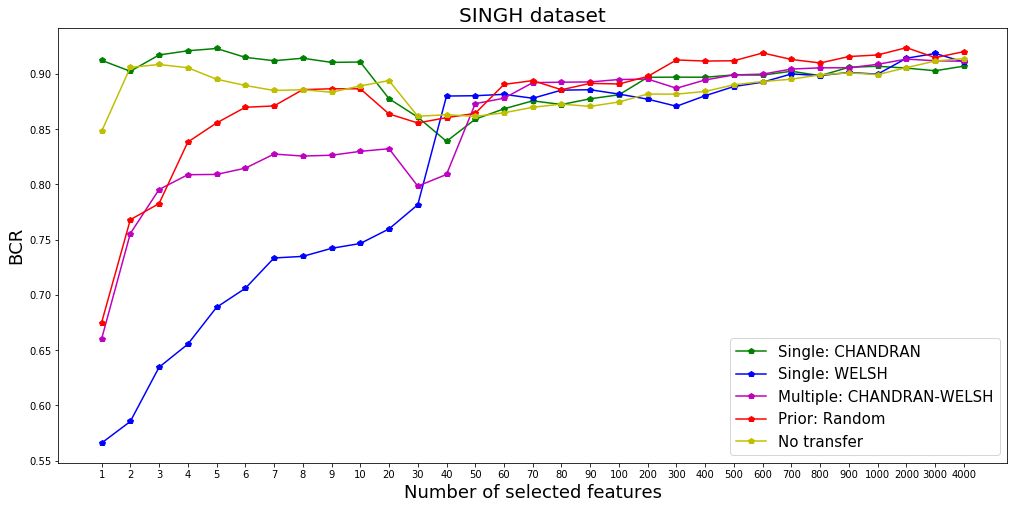

In [14]:
str_features = [str(item) for item in n_features_list]

plt.figure(figsize=(17,8))
plt.plot(str_features, BCR[2,:], 'g-p', label="Single: CHANDRAN" )
plt.plot(str_features, BCR[4,:], 'b-p', label="Single: WELSH" )
plt.plot(str_features, BCR_multiple[2,:], 'm-p', label="Multiple: CHANDRAN-WELSH" )
plt.plot(str_features, BCR_rnd[0,:], 'r-p', label="Prior: Random" )
plt.plot(str_features, BCR_nt[0,:], 'y-p', label="No transfer" )
plt.xlabel("Number of selected features", fontsize=18)
plt.ylabel("BCR", fontsize = 18)
plt.title("SINGH dataset", fontsize=20)
plt.legend(loc="best", fontsize = 15)

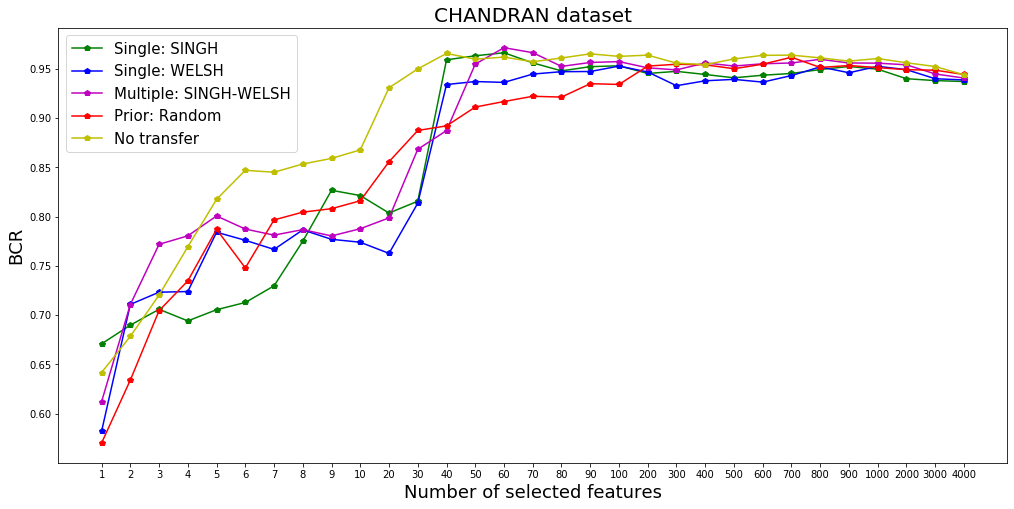

In [15]:
plt.figure(figsize=(17,8))
plt.plot(str_features, BCR[0,:], 'g-p', label="Single: SINGH" )
plt.plot(str_features, BCR[5,:], 'b-p', label="Single: WELSH" )
plt.plot(str_features, BCR_multiple[1,:], 'm-p', label="Multiple: SINGH-WELSH" )
plt.plot(str_features, BCR_rnd[1,:], 'r-p', label="Prior: Random" )
plt.plot(str_features, BCR_nt[1,:], 'y-p', label="No transfer" )
plt.xlabel("Number of selected features", fontsize=18)
plt.ylabel("BCR", fontsize = 18)
plt.title("CHANDRAN dataset", fontsize=20)
plt.legend(loc="best", fontsize = 15)

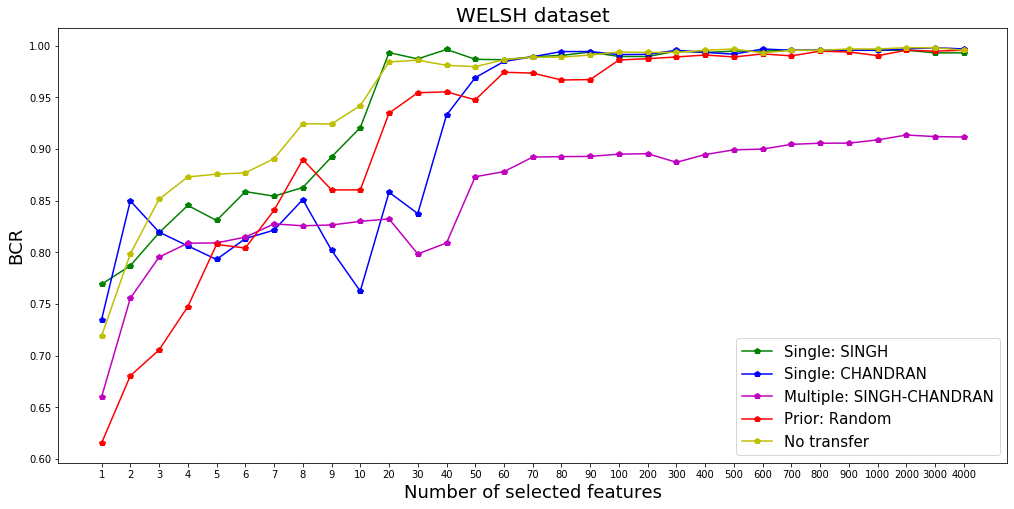

In [16]:
plt.figure(figsize=(17,8))
plt.plot(str_features, BCR[1,:], 'g-p', label="Single: SINGH" )
plt.plot(str_features, BCR[3,:], 'b-p', label="Single: CHANDRAN" )
plt.plot(str_features, BCR_multiple[2,:], 'm-p', label="Multiple: SINGH-CHANDRAN" )
plt.plot(str_features, BCR_rnd[2,:], 'r-p', label="Prior: Random" )
plt.plot(str_features, BCR_nt[2,:], 'y-p', label="No transfer" )
plt.xlabel("Number of selected features", fontsize=18)
plt.ylabel("BCR", fontsize = 18)
plt.title("WELSH dataset", fontsize=20)
plt.legend(loc="best", fontsize = 15)

## 2) Kuncheva index

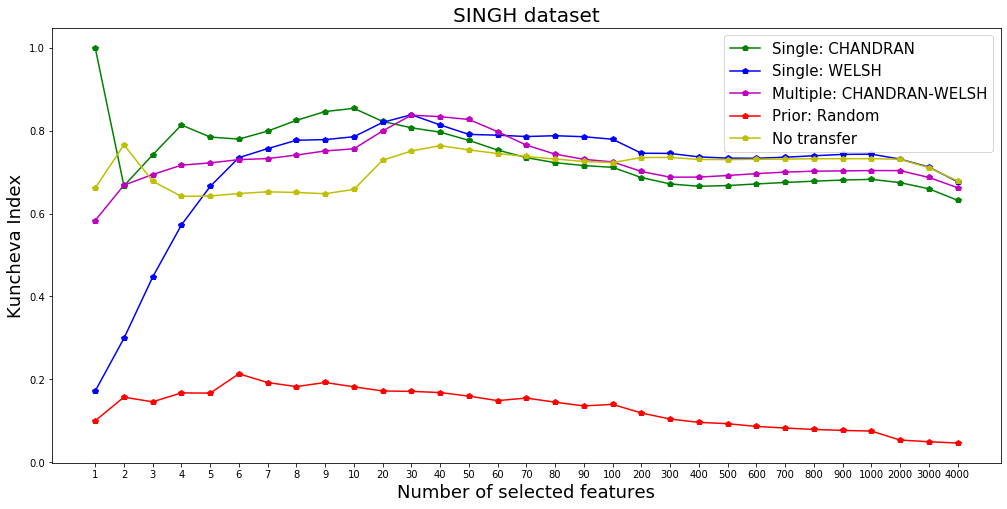

In [17]:
plt.figure(figsize=(17,8))
plt.plot(str_features, kuncheva[2,:], 'g-p', label="Single: CHANDRAN" )
plt.plot(str_features, kuncheva[4,:], 'b-p', label="Single: WELSH" )
plt.plot(str_features, kuncheva_multiple[2,:], 'm-p', label="Multiple: CHANDRAN-WELSH" )
plt.plot(str_features, kuncheva_rnd[0,:], 'r-p', label="Prior: Random" )
plt.plot(str_features, kuncheva_nt[0,:], 'y-p', label="No transfer" )
plt.xlabel("Number of selected features", fontsize=18)
plt.ylabel("Kuncheva Index", fontsize = 18)
plt.title("SINGH dataset", fontsize=20)
plt.legend(loc="best", fontsize = 15)

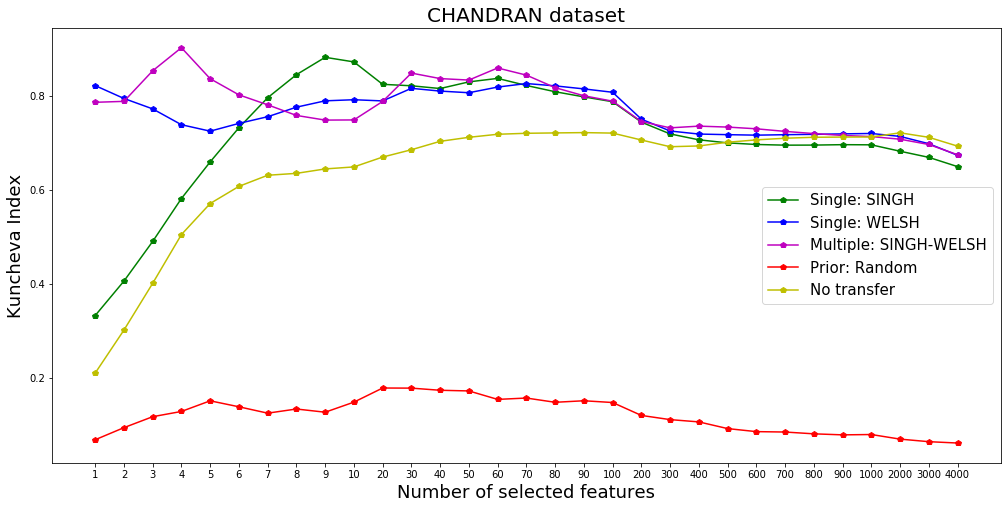

In [18]:
plt.figure(figsize=(17,8))
plt.plot(str_features, kuncheva[0,:], 'g-p', label="Single: SINGH" )
plt.plot(str_features, kuncheva[5,:], 'b-p', label="Single: WELSH" )
plt.plot(str_features, kuncheva_multiple[1,:], 'm-p', label="Multiple: SINGH-WELSH" )
plt.plot(str_features, kuncheva_rnd[1,:], 'r-p', label="Prior: Random" )
plt.plot(str_features, kuncheva_nt[1,:], 'y-p', label="No transfer" )
plt.xlabel("Number of selected features", fontsize=18)
plt.ylabel("Kuncheva Index", fontsize = 18)
plt.title("CHANDRAN dataset", fontsize=20)
plt.legend(loc="best", fontsize = 15)

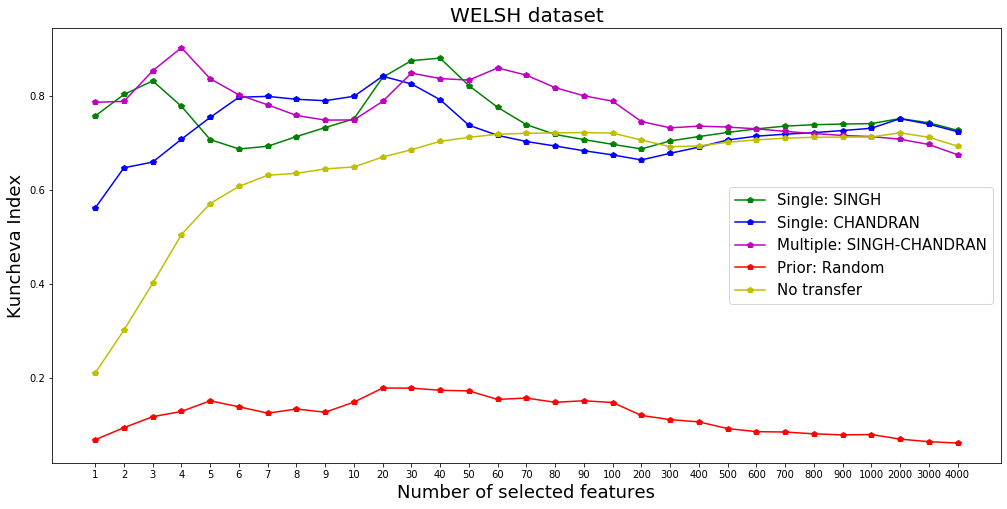

In [19]:
plt.figure(figsize=(17,8))
plt.plot(str_features, kuncheva[1,:], 'g-p', label="Single: SINGH" )
plt.plot(str_features, kuncheva[3,:], 'b-p', label="Single: CHANDRAN" )
plt.plot(str_features, kuncheva_multiple[1,:], 'm-p', label="Multiple: SINGH-CHANDRAN" )
plt.plot(str_features, kuncheva_rnd[1,:], 'r-p', label="Prior: Random" )
plt.plot(str_features, kuncheva_nt[1,:], 'y-p', label="No transfer" )
plt.xlabel("Number of selected features", fontsize=18)
plt.ylabel("Kuncheva Index", fontsize = 18)
plt.title("WELSH dataset", fontsize=20)
plt.legend(loc="best", fontsize = 15)

## 3) Testing the impact of the value of the prior relevance weight

In the experiments described above the value B = 10 was chosen. The influence of a specific choice of
the B value on stability and classification performances is analyzed in this section. 

It is detailed experiments with multiple transfer since this approach offers the best results so far. The range of and datasets considered for this section are B = {1, 2, 5, 10, 100, 1000} on Welsh. 

In [20]:
BCR_multiple = np.zeros((6,len(n_features_list)))
kuncheva_multiple = np.zeros((6,len(n_features_list)))


##From SINGH-CHANDRAN to WELSH
b_list = [1, 2, 5, 10, 100, 1000]
count = 0
for b in (b_list):
    for i, val in enumerate(n_features_list):
        a, x = learn_transfer_paper(k1=420, k2=385, X_s1=x_singh, y_s1=y_singh, X_s2=x_chandran, y_s2=y_chandran, 
                                    X=x_welsh, y=y_welsh, Dt=WELSH, iterate=20, S=val, a_priori=True, transfer= 1, b=b)

        BCR_multiple[count,i] = a
        kuncheva_multiple[count,i] = x
        
    count += 1

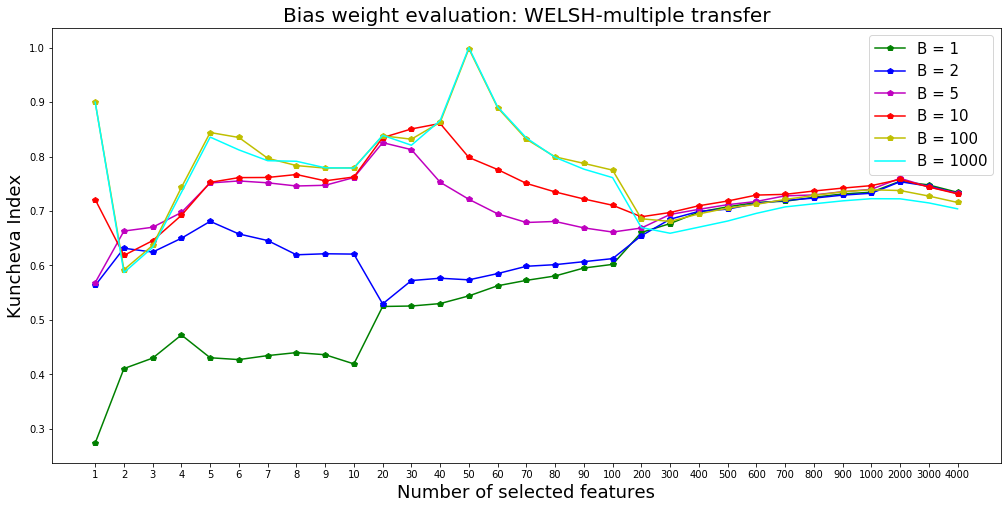

In [21]:
str_features = [str(item) for item in n_features_list]
plt.figure(figsize=(17,8))
plt.plot(str_features, kuncheva_multiple[0,:], 'g-p', label="B = 1" )
plt.plot(str_features, kuncheva_multiple[1,:], 'b-p', label="B = 2" )
plt.plot(str_features, kuncheva_multiple[2,:], 'm-p', label="B = 5" )
plt.plot(str_features, kuncheva_multiple[3,:], 'r-p', label="B = 10" )
plt.plot(str_features, kuncheva_multiple[4,:], 'y-p', label="B = 100" )
plt.plot(str_features, kuncheva_multiple[5,:], 'cyan', label="B = 1000" )
plt.xlabel("Number of selected features", fontsize=18)
plt.ylabel("Kuncheva Index", fontsize = 18)
plt.title("Bias weight evaluation: WELSH-multiple transfer", fontsize=20)
plt.legend(loc="best", fontsize = 15)

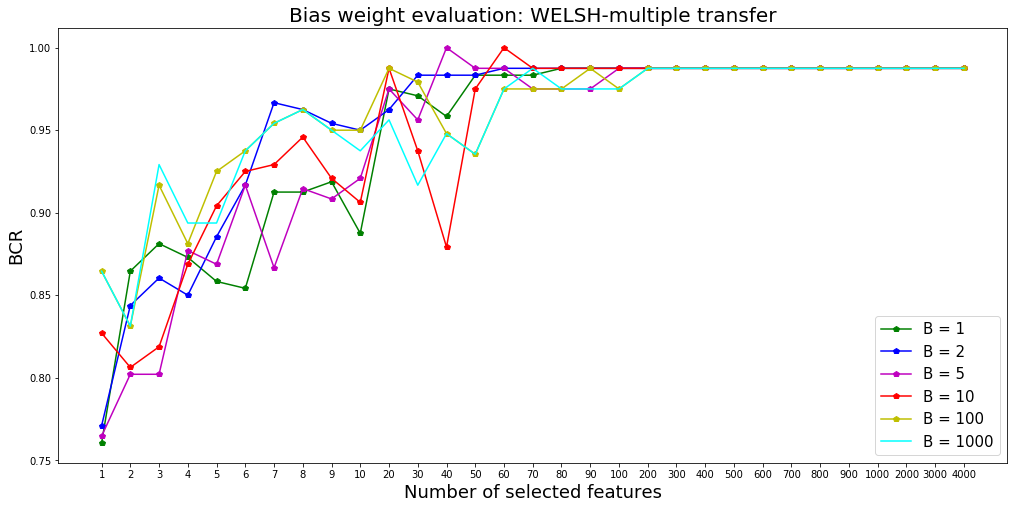

In [22]:
plt.figure(figsize=(17,8))
plt.plot(str_features, BCR_multiple[0,:], 'g-p', label="B = 1" )
plt.plot(str_features, BCR_multiple[1,:], 'b-p', label="B = 2" )
plt.plot(str_features, BCR_multiple[2,:], 'm-p', label="B = 5" )
plt.plot(str_features, BCR_multiple[3,:], 'r-p', label="B = 10" )
plt.plot(str_features, BCR_multiple[4,:], 'y-p', label="B = 100" )
plt.plot(str_features, BCR_multiple[5,:], 'cyan', label="B = 1000" )
plt.xlabel("Number of selected features", fontsize=18)
plt.ylabel("BCR", fontsize = 18)
plt.title("Bias weight evaluation: WELSH-multiple transfer", fontsize=20)
plt.legend(loc="best", fontsize = 15)

<br></br>
# <i><u>Results and conclusions so far
    
    
The results derived from our implementation of the paper’s experiments were quite underperforming. It seems that most of the author’s claims regarding the results of multiple transfer have been not met for BCR though for Kuncheva's they are a bit more solid. The training-test partition is another suspect of possible element to generate this discrepancies, specially in the Welsh dataset. With a total number of 34 samples and only 8 of them being cases, I was quite suspicious that its results wouldn't shine.

This results regarding multiple transfer might have been related with an specific issue:
During the function used to obtain the z vector for multiple transfer, I tried to use the author’s proposed n_features for each different dataset comparisons ( ) I found out that the intersected feature size were not even close to 50 ( around 20 or even less). To overcome this issue (and at the same time trying to keep a intersect of size 50) It was considered to use higher n_features so that we were able to generate at least an intersect of 50. Probably by doing this I was introducing features not that relevant or significative into our weighted z vector.  It might explain why the multiple transfer learn performed mostly low in the BCR metric for the 3 datasets. Regarding stability, none reached 1 although the results were quite similar to the paper’s original ones.

Moreover, when comparing the impact of the prior relevance weight, the results were quite similar to the author’s original results. Results show that the higher the B value the stronger the stability peak around 50 features. This is a logical consequence of the initial ranking of 50 features.  The stability is not influenced for signature sizes significantly larger than 50 features except for  B in range  [100,1000] and not by much. For signature sizes smaller than 50 a better stability is obtained with B in the range [5, 1000]. Most interestingly is that the BCR results are increasing at the same rate for all the values of B. That was not observed in the original paper, but then again we are not quite trustful of the multiple transfer learning implementation for the reasons above mentioned.


#### All of these new results led me to try to implement my own rationale to test the author's assumptions

<br></br>
# <i><u>New implementation of the methodology


All this preprocess was performed as we wanted to defy and test the authors' original assumption:

   "*Our modeling assumption is however that the features extracted from similar tasks provide useful information as compared to selecting features only from a single domain DT . This assumption is confirmed by our practical experiments reported in section 5*" [4].
   
   


<div style="text-align: justify">Although through sheer practicallity, they assumed that feature indexes were equivalent enough between datasets using the above reasoning. That was proven hard to belive, provided Welsh dataset was completely disordered. Even if the assumption was plausible, you would have been comparing different features with each another. Again, it can be explained through practicallity of how to handle this kind of datasets, but we considered it interesting enough to try and provide another take on the issue.</div>

<br></br>
## <i><u>Importing data sets: <font color = "red">Singh<font color = "black">,</font> Chandran<font color = "black">,</font> Welsh</font></u></i>
<br></br>
<div style="text-align: justify">We need to mention that we have slightly altered the original files through R to implement our own take on their experiments. Feature names were altered slightly to macth the other datasets (unifying them) and Welsh dataset was reduced to the number of common features with the other two datasets.</div>



In [23]:
#We read all the datasets into pandas dataframes
SINGH    = pd.read_csv("data/singh_new.csv")
CHANDRAN = pd.read_csv("data/chandran_new.csv")
WELSH  = pd.read_csv("data/welsh_subset.csv")

print(SINGH.shape)
print(CHANDRAN.shape)
print(WELSH.shape)

(102, 12626)
(104, 12626)
(34, 12601)


<br></br>
## <i><u>Function for getting <font color ="blue">z vector</font>: single transfer</u></i>

In this version of the single transfer method <i><b><font color="blue">I won't assume</font></b></i> that the features will mostly be ordered in the same way in the different datasets, in contrast with what the authors assume. In fact it can be observed that this assumption is not true for the Welsh dataset, that presents different feature order and composition, so the impact of the authors assumption can be strong enough to disturb the interpretation of the results.

With this in mind it was proposed a different routine for building the <b><i>"z vector"</i> </b> that carries the <b><i>a priori</i></b> information used to favour some features over the rest. It just consists in locating exactly the index of the corresponding feature in the target dataset. To do so, I have already modified the original files to make sure all the features have an equivalent in the three datasets.

In [24]:
## Function for getting the "z" vector that will be used for PS-l2-AROM algorithm in the case of single transfer

def get_z_vector_single(Ds, Dt, b=10):
    """Ds is the source dataset and Dt is the target dataset"""
    X_s = Ds.values[:,:-1].astype(np.float) #All data columns except labels
    y_s = Ds.values[:, -1] #Labels
    
    X_50 = SelectKBest(f_classif, k=50).fit(X_s, y_s).get_support(indices=True) #Select 50 best using ANOVA
    
    probe_names = list(Ds)[0:-1] #List of chip probes
    probe_names_50 = [probe_names[i] for i in X_50] #List of 50 best probe names
    
    #Now we get the list of indices corresponding to selected 50 best in Dt
    
    indices_Dt = []
    
    for i in probe_names_50:
        if i in list(Dt):
            indices_Dt.append(list(Dt).index(i))
    
    
    z = np.ones(Dt.shape[1]-1)
    z[indices_Dt] = b #We assign a value of 10 to those features found to be best in Ds
    
    return z, len(indices_Dt)    

<div style="text-align: justify">Is important to notice here that only in those cases in which the selected feature is present in the target dataset we use it to define the z vector. We know that this could lead to a z vector with less than 50 features with <i>a priori</i> knowledge (in this case favoured with a default value of 10). This is a limitation of this implementation; however, the potential impact with this three datasets is minimum since all of them share the vast majority of the features. The probability of finding a certain feature selected from the Singh or Chandran dataset in the Welsh dataset is about 99.8%.To make it extendable to datasets sharing few features (genes) we should implement a routine to go down the ranked list of features in the source dataset till we get the desired number of features with the condition of being present in the target dataset.</div>

<br></br>
## <i><u>Function for getting <font color ="blue">z vector</font>: multiple transfer</u></i>

In this case, we use a different rationale for selecting the genes that will be used for transferring learning to the target dataset. We take the intersection of both datasets's 50 best features. As this won't give 50 common features, we complete up to 50 with those from 50 best that were not in the intersection.

In order to test the author's original assumption I believe this option is an interesting take, provided that this approach lies under the authors' words "*Our modeling assumption is however that the features extracted from similar tasks provide useful information as compared to selecting features only from a single domain DT*"[4]. If features extracted from similar tasks provide useful information, relevant features from different source datasets (although not necessarily present in both) might yield equivalent results. Moreover, it will account for the initial skepticism regarding the author's implementation of the intersect or, at the very least, test if this rationale is able to yield better results. 

Consequently it was decided to test it by completing the final z vector with the rest (non intersecting) features of each 50-best ranked list could improve the results.


In [25]:
## Function for getting the "z" vector that will be used for PS-l2-AROM algorithm in the case of dual transfer

def get_z_vector_multiple_1(Ds1,Ds2, Dt, b=10):
    """Ds1 is the first source dataset, Ds2 is the second and Dt the target"""
    X_s1 = Ds1.values[:,:-1].astype(np.float) #All data columns except labels
    y_s1 = Ds1.values[:, -1] #Labels
    
    X_s2 = Ds2.values[:,:-1].astype(np.float) #All data columns except labels
    y_s2 = Ds2.values[:, -1] #Labels
    
    XS1_50 = SelectKBest(f_classif, k=50).fit(X_s1, y_s1).get_support(indices=True) #Select 50 best using ANOVA
    XS2_50 = SelectKBest(f_classif, k=50).fit(X_s2, y_s2).get_support(indices=True) #Select 50 best using ANOVA
    
    probe_names_Ds1 = list(Ds1)[0:-1] #List of chip probes for Ds1
    probe_names_Ds2 = list(Ds2)[0:-1] #List of chip probes for Ds2

    probe_names_50_Ds1 = [probe_names_Ds1[i] for i in XS1_50] #List of 50 best probe names for Ds1
    probe_names_50_Ds2 = [probe_names_Ds2[i] for i in XS2_50] #List of 50 best probe names for Ds2
    
    #Intersection and completion with the rest best 50 (non intersecting)
    intersect = list(set(probe_names_50_Ds1).intersection(probe_names_50_Ds2))
    
    if len(intersect) < 50:
        Ds1_50_minus = [i for i in probe_names_50_Ds1 if i not in intersect]
        Ds2_50_minus = [i for i in probe_names_50_Ds2 if i not in intersect]
    
        if (50-len(intersect))%2 == 0:
            intersect += Ds1_50_minus[0:int((50-len(intersect))/2)]+Ds2_50_minus[0:int((50-len(intersect))/2)]
        else:
            intersect += Ds1_50_minus[0:int((51-len(intersect))/2)]+Ds2_50_minus[0:int((49-len(intersect))/2)]
            
    #Now we get the list of indices corresponding to selected 50 best in Dt
    indices_Dt = []
    
    for i in intersect:
        if i in list(Dt):
            indices_Dt.append(list(Dt).index(i))
    
    
    z = np.ones(Dt.shape[1]-1)
    z[indices_Dt] = b
    
    return z, len(indices_Dt)

<br></br>
## <i><u>Function for getting <font color ="blue">z vector</font>: random transfer</u></i>

In [26]:
## Function for getting the "z" vector that will be used for PS-l2-AROM algorithm in the case of single transfer
def get_z_vector_random(Dt, S):
    """Dt is the target dataset and S is the number of features to select"""
    
    n_features = len(list(Dt))-1
    
    rand_choice = random.sample(range(n_features), S)
    
    #Now we get the list of indices corresponding to selected 50 best in Dt   
    
    z = np.ones(Dt.shape[1]-1)
    z[rand_choice] = 10 #We assign a value of 10 to those features selected randomly
    
    return z

<br></br>
# <i><u>Main Function</u></i>  
### <i><u>Integrate all methods and calculate <font color="blue">BCR</font> and <font color="red">stability measure</font></u></i>

In [27]:
### Main function integrating all methods-------------------------------------------------------------------------------
    
def learn_transfer(Ds1=None,Ds2=None,Dt=None,k=0,S=0,a_priori=True,transfer=None): #k = num of iterations
                                                                                    #S = size of feature set Kuncheva
                                                                                    #Ds1 = source 1 // Ds2 = source 2
                                                                                    #Dt = target dataset
    
    var_rank_matrix = np.zeros((k,Dt.shape[1]-1)) #Matrix with results of PS-l2-AROM of all iterations (data splits)
    BCR = [] #Accumulate accuracy measures
    
    X = Dt.values[:,:-1].astype(np.float) #All data columns except labels
    y = Dt.values[:, -1] #Labels
        
    for i in range(0,k):
    
        X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.1, random_state = i) #Data split (iterating seed)
        
        scaler = preprocessing.StandardScaler().fit(X_tr) #Scale data : mean ≈ 0, std ≈ 1
        X_train_scaled = scaler.transform(X_tr)
        X_test_scaled = scaler.transform(X_te)
        
        if a_priori == True:  #Select method depending on the input
            if transfer == 0:
                z, num_f = get_z_vector_single(Ds1,Dt)
            if transfer == 1:
                z, num_f = get_z_vector_multiple_1(Ds1,Ds2,Dt)
            if transfer == "random":
                       z = get_z_vector_random(Dt, S)
            
            
        else:
            z = np.ones(X.shape[1])
        
        
        remove_order = variable_ranking(X_train_scaled,y_tr,z)
        
        var_rank_matrix[i,:] = remove_order #For computation of Kuncheva score
        
        
        ##Now the prediction measure
        X_train_final = X_train_scaled[:,remove_order[0:S]]
        X_test_final  = X_test_scaled[:, remove_order[0:S]]
        
        clf = SVC(kernel = "linear", C = 1, random_state = 0)
        clf.fit(X_train_final, y_tr)
        y_pred = clf.predict(X_test_final)
                
        conf = confusion_matrix(y_te, y_pred)
        
        if conf.shape[0] == 2:
            TN = int(conf[0][0])
            TP = int(conf[1][1])
            FP = int(conf[0][1])
            FN = int(conf[1][0])
            
            if TP+FP+TN+FN == 0:
                BCR.append(1)
                
            elif TN+FN == 0:
                BCR.append((TP/(TP+FP))/2)
                
            elif TP+FP == 0:
                BCR.append((TN/(TN+FN))/2)
                
                
            else:
                BCR.append(((TP/(TP+FP))+(TN/(TN+FN)))/2)
        
        else:
            BCR.append(1)
        
    kuncheva = kuncheva_index(S, k, var_rank_matrix)
    
    return np.mean(BCR), kuncheva

<br></br>
## Computing: Single transfer

In [28]:
##From SINGH to CHANDRAN
BCR = np.zeros((6,len(n_features_list)))
kuncheva = np.zeros((6,len(n_features_list)))


for i, val in enumerate(n_features_list):
    a, b  = learn_transfer(Ds1=SINGH, Dt=CHANDRAN, k=200, S=val, a_priori=True, transfer = 0)
        
    BCR[0,i] = a
    kuncheva[0,i] = b

    
##From SINGH to WELSH

for i, val in enumerate(n_features_list):
    a, b = learn_transfer(Ds1=SINGH, Dt=WELSH, k=200, S=val, a_priori=True, transfer = 0)
        
    BCR[1,i] = a
    kuncheva[1,i] = b

        

##From CHANDRAN to SINGH

for i, val in enumerate(n_features_list):
    a, b = learn_transfer(Ds1=CHANDRAN, Dt=SINGH, k=200, S=val, a_priori=True, transfer = 0)
        
    BCR[2,i] = a
    kuncheva[2,i] = b

    
##From CHANDRAN to WELSH

for i, val in enumerate(n_features_list):
    a, b = learn_transfer(Ds1=CHANDRAN, Dt=WELSH, k=200, S=val, a_priori=True, transfer = 0)
        
    BCR[3,i] = a
    kuncheva[3,i] = b


##From WELSH to SINGH


for i, val in enumerate(n_features_list):
    a, b = learn_transfer(Ds1=WELSH, Dt=SINGH, k=200, S=val, a_priori=True, transfer = 0)
        
    BCR[4,i] = a
    kuncheva[4,i] = b

    
##From WELSH to CHANDRAN

for i, val in enumerate(n_features_list):
    a, b= learn_transfer(Ds1=WELSH, Dt=CHANDRAN, k=200, S=val, a_priori=True, transfer = 0)
        
    BCR[5,i] = a
    kuncheva[5,i] = b



<br></br>
## Computing: Multiple transfer
        

In [29]:
BCR_multiple = np.zeros((3,len(n_features_list)))
kuncheva_multiple = np.zeros((3,len(n_features_list)))


##From SINGH-CHANDRAN to WELSH

for i, val in enumerate(n_features_list):
    a, b= learn_transfer(Ds1=SINGH, Ds2=CHANDRAN, Dt=WELSH, k=200, S=val, a_priori=True, transfer = 1)
        
    BCR_multiple[0,i] = a
    kuncheva_multiple[0,i] = b

    
##From SINGH-WELSH to CHANDRAN

for i, val in enumerate(n_features_list):
    a, b = learn_transfer(Ds1=SINGH, Ds2=WELSH, Dt=CHANDRAN, k=200, S=val, a_priori=True, transfer = 1)
        
    BCR_multiple[1,i] = a
    kuncheva_multiple[1,i] = b

        

##From CHANDRAN-WELSH to SINGH

for i, val in enumerate(n_features_list):
    a, b = learn_transfer(Ds1=CHANDRAN, Ds2=WELSH, Dt=SINGH, k=200, S=val, a_priori=True, transfer = 1)
        
    BCR_multiple[2,i] = a
    kuncheva_multiple[2,i] = b

    

<br></br>
## Computing: No transfer

In [30]:
BCR_nt = np.zeros((3,len(n_features_list)))
kuncheva_nt = np.zeros((3,len(n_features_list)))


## SINGH

for i, val in enumerate(n_features_list):
    a, b  = learn_transfer(Dt=SINGH, k=200, S=val, a_priori=False)
        
    BCR_nt[0,i] = a
    kuncheva_nt[0,i] = b
    
## CHANDRAN

for i, val in enumerate(n_features_list):
    a, b = learn_transfer(Dt=CHANDRAN, k=200, S=val, a_priori=False)
        
    BCR_nt[1,i] = a
    kuncheva_nt[1,i] = b

        

## WELSH

for i, val in enumerate(n_features_list):
    a, b = learn_transfer(Dt=WELSH, k=200, S=val, a_priori=False)
        
    BCR_nt[2,i] = a
    kuncheva_nt[2,i] = b


<br></br>
## Computing: Random transfer

In [31]:
BCR_rnd = np.zeros((3,len(n_features_list)))
kuncheva_rnd = np.zeros((3,len(n_features_list)))

## SINGH

for i, val in enumerate(n_features_list):
    a, b = learn_transfer(Dt=SINGH, k=200, S=val, a_priori=True, transfer="random")
        
    BCR_rnd[0,i] = a
    kuncheva_rnd[0,i] = b
    
## CHANDRAN

for i, val in enumerate(n_features_list):
    a, b = learn_transfer(Dt=CHANDRAN, k=200, S=val, a_priori=True, transfer="random")
        
    BCR_rnd[1,i] = a
    kuncheva_rnd[1,i] = b
        

## WELSH

for i, val in enumerate(n_features_list):
    a, b = learn_transfer(Dt=WELSH, k=200, S=val, a_priori=True, transfer="random")
        
    BCR_rnd[2,i] = a
    kuncheva_rnd[2,i] = b

<br></br>
# Plotting results

## 1) BCR

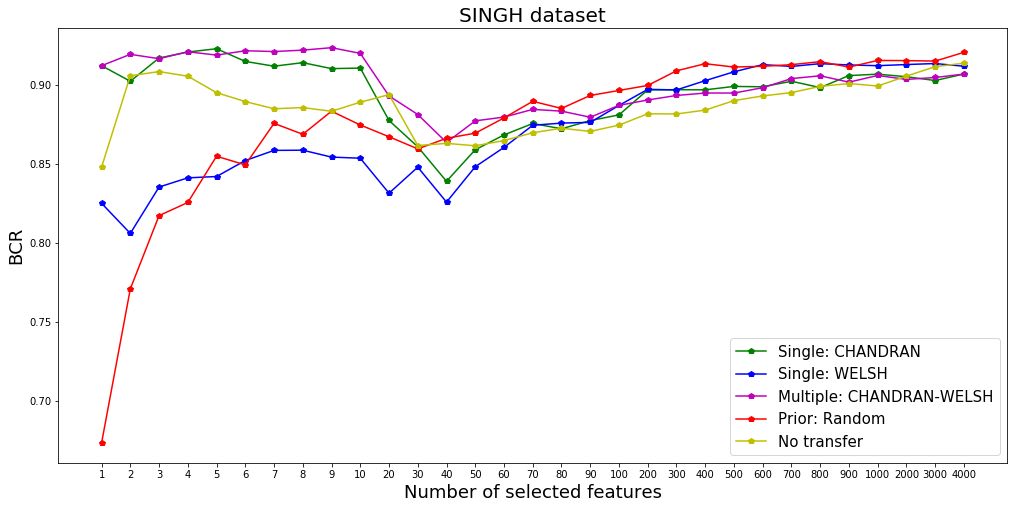

In [32]:
str_features = [str(item) for item in n_features_list]

plt.figure(figsize=(17,8))
plt.plot(str_features, BCR[2,:], 'g-p', label="Single: CHANDRAN" )
plt.plot(str_features, BCR[4,:], 'b-p', label="Single: WELSH" )
plt.plot(str_features, BCR_multiple[2,:], 'm-p', label="Multiple: CHANDRAN-WELSH" )
plt.plot(str_features, BCR_rnd[0,:], 'r-p', label="Prior: Random" )
plt.plot(str_features, BCR_nt[0,:], 'y-p', label="No transfer" )
plt.xlabel("Number of selected features", fontsize=18)
plt.ylabel("BCR", fontsize = 18)
plt.title("SINGH dataset", fontsize=20)
plt.legend(loc="best", fontsize = 15)


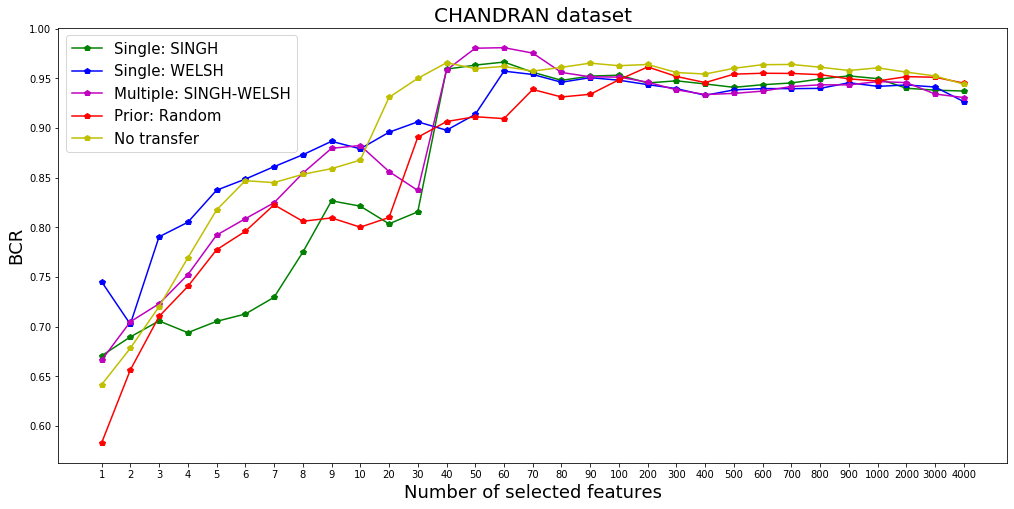

In [33]:
plt.figure(figsize=(17,8))
plt.plot(str_features, BCR[0,:], 'g-p', label="Single: SINGH" )
plt.plot(str_features, BCR[5,:], 'b-p', label="Single: WELSH" )
plt.plot(str_features, BCR_multiple[1,:], 'm-p', label="Multiple: SINGH-WELSH" )
plt.plot(str_features, BCR_rnd[1,:], 'r-p', label="Prior: Random" )
plt.plot(str_features, BCR_nt[1,:], 'y-p', label="No transfer" )
plt.xlabel("Number of selected features", fontsize=18)
plt.ylabel("BCR", fontsize = 18)
plt.title("CHANDRAN dataset", fontsize=20)
plt.legend(loc="best", fontsize = 15)

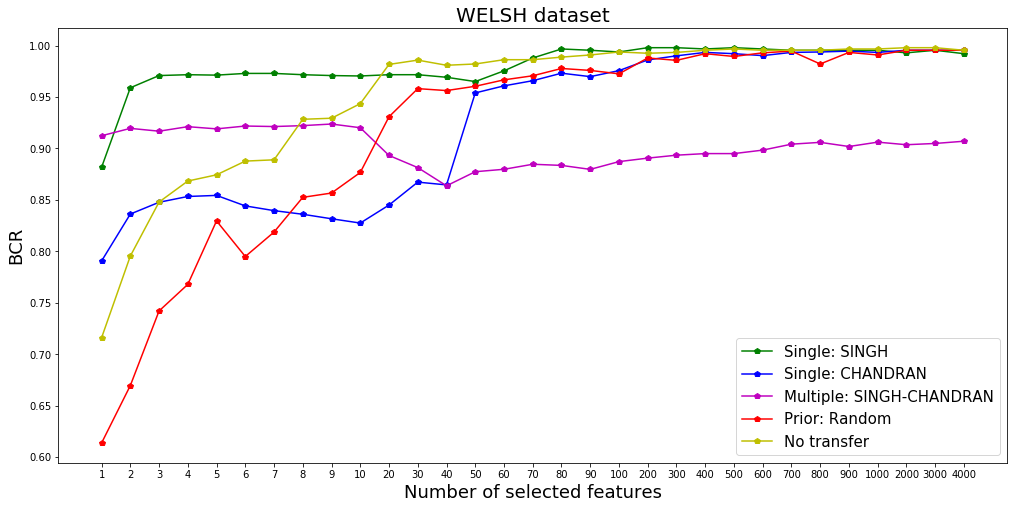

In [34]:
plt.figure(figsize=(17,8))
plt.plot(str_features, BCR[1,:], 'g-p', label="Single: SINGH" )
plt.plot(str_features, BCR[3,:], 'b-p', label="Single: CHANDRAN" )
plt.plot(str_features, BCR_multiple[2,:], 'm-p', label="Multiple: SINGH-CHANDRAN" )
plt.plot(str_features, BCR_rnd[2,:], 'r-p', label="Prior: Random" )
plt.plot(str_features, BCR_nt[2,:], 'y-p', label="No transfer" )
plt.xlabel("Number of selected features", fontsize=18)
plt.ylabel("BCR", fontsize = 18)
plt.title("WELSH dataset", fontsize=20)
plt.legend(loc="best", fontsize = 15)

## 2) Kuncheva index

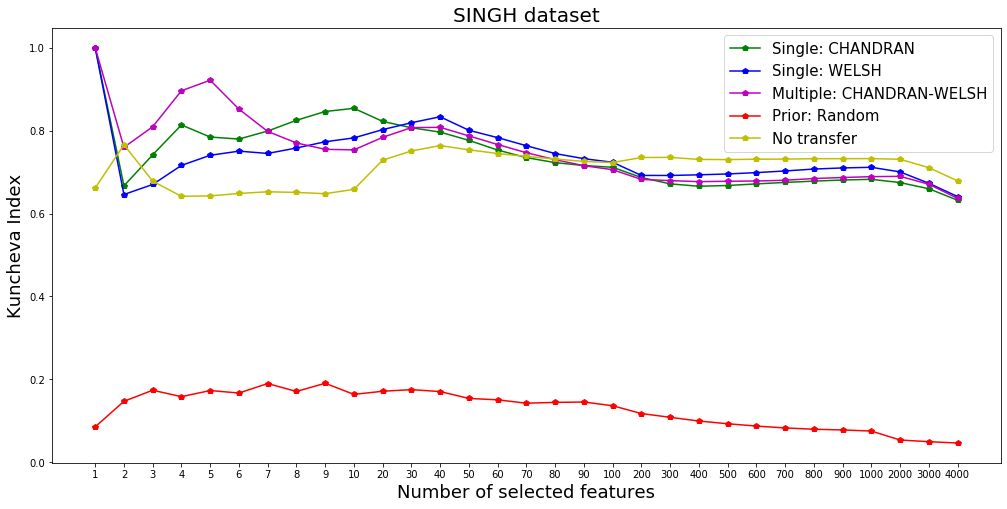

In [35]:
plt.figure(figsize=(17,8))
plt.plot(str_features, kuncheva[2,:], 'g-p', label="Single: CHANDRAN" )
plt.plot(str_features, kuncheva[4,:], 'b-p', label="Single: WELSH" )
plt.plot(str_features, kuncheva_multiple[2,:], 'm-p', label="Multiple: CHANDRAN-WELSH" )
plt.plot(str_features, kuncheva_rnd[0,:], 'r-p', label="Prior: Random" )
plt.plot(str_features, kuncheva_nt[0,:], 'y-p', label="No transfer" )
plt.xlabel("Number of selected features", fontsize=18)
plt.ylabel("Kuncheva Index", fontsize = 18)
plt.title("SINGH dataset", fontsize=20)
plt.legend(loc="best", fontsize = 15)

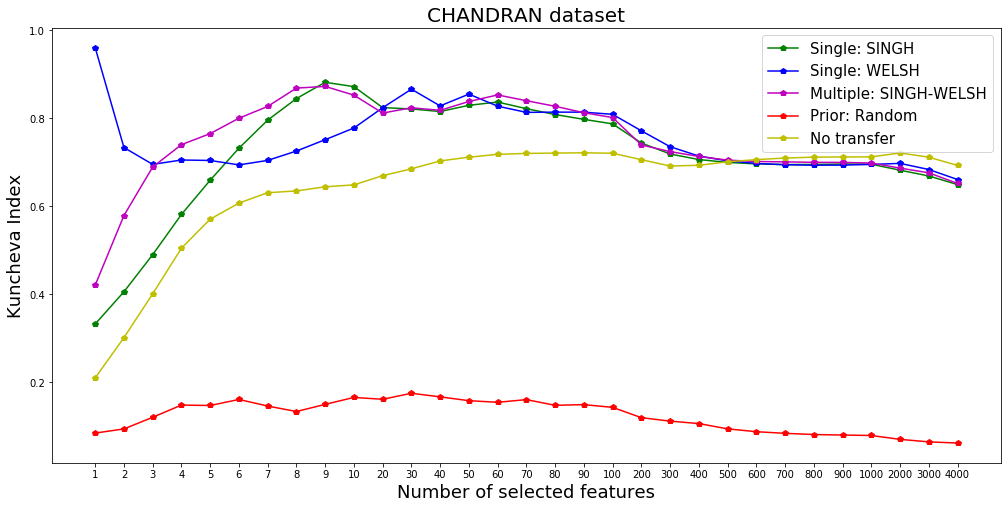

In [36]:
plt.figure(figsize=(17,8))
plt.plot(str_features, kuncheva[0,:], 'g-p', label="Single: SINGH" )
plt.plot(str_features, kuncheva[5,:], 'b-p', label="Single: WELSH" )
plt.plot(str_features, kuncheva_multiple[1,:], 'm-p', label="Multiple: SINGH-WELSH" )
plt.plot(str_features, kuncheva_rnd[1,:], 'r-p', label="Prior: Random" )
plt.plot(str_features, kuncheva_nt[1,:], 'y-p', label="No transfer" )
plt.xlabel("Number of selected features", fontsize=18)
plt.ylabel("Kuncheva Index", fontsize = 18)
plt.title("CHANDRAN dataset", fontsize=20)
plt.legend(loc="best", fontsize = 15)

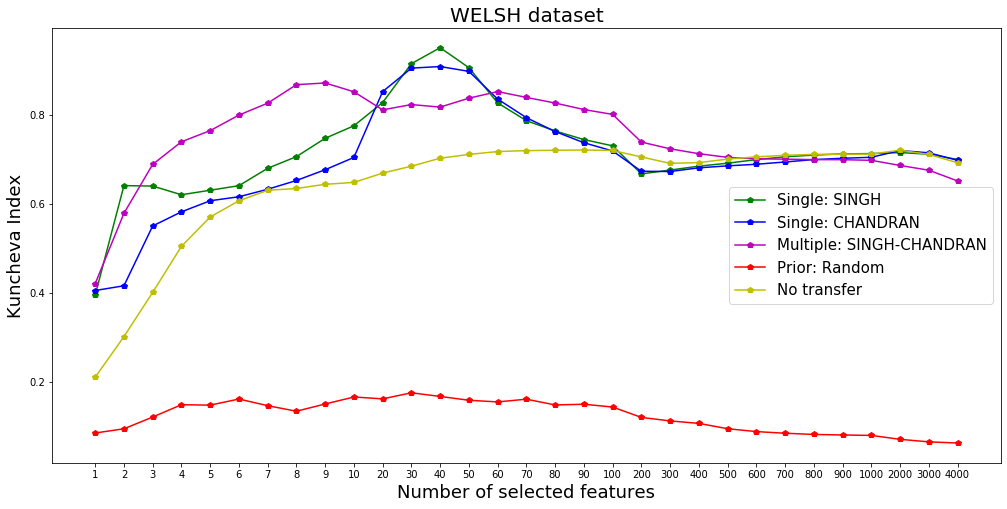

In [37]:
plt.figure(figsize=(17,8))
plt.plot(str_features, kuncheva[1,:], 'g-p', label="Single: SINGH" )
plt.plot(str_features, kuncheva[3,:], 'b-p', label="Single: CHANDRAN" )
plt.plot(str_features, kuncheva_multiple[1,:], 'm-p', label="Multiple: SINGH-CHANDRAN" )
plt.plot(str_features, kuncheva_rnd[1,:], 'r-p', label="Prior: Random" )
plt.plot(str_features, kuncheva_nt[1,:], 'y-p', label="No transfer" )
plt.xlabel("Number of selected features", fontsize=18)
plt.ylabel("Kuncheva Index", fontsize = 18)
plt.title("WELSH dataset", fontsize=20)
plt.legend(loc="best", fontsize = 15)

<br></br>
# <i><u>Conclusions and <font color="blue">Discussion</font></u></i>

BCR results indicate in general that transferring learning is a good approach for this kind of problems (microarrays). It have been demonstrated that using transfer learning is better than not using any previously acquired learning. It can be observed that the Kuncheva index has higher values when using single and multiple transfer learning than when not using it, so the impact of sampling in different ways is lower with this technique. 
One of the most interesting results is that we can get more than 15% of higher accuracy, measured by BCR, when using very low number of features and a transfer learning approach when compared to the no transfer approach (observed with the WELSH dataset --> this is the relevant one as seems to be the most different). This result indicates that there could be some fundamental features (genes) underlying the development of different types of cancer, and those could have a strong predicting power from a clinical point of view. 

In comparison with the pipeline of the authors with respect to the multiple transfer, my own rationale seems to improve the results of accuracy when using the combined transfer learning as we expected. This makes sense since we are using the best ranked features from each source dataset instead of scarifying the best ones to obtain an intersection of 50. The results seem to support the original paper's[4] results for the most part, specially when evaluating the benefits of both single learning transfer and stability. As in the original paper, maximal stability is often reached around 50 features (give or take), which comes with no surprise since precisely 50 genes are weighted during the selection on the target domain.


Another relevant point is the proper preprocessing of the datasets. In this case I decided to subset the Welsh dataset to finally get only the features that intersected with those of Singh and Chandran (the two latter have exactly the same composition). I also did not take the assumption of the authors of the similar-enough ordering of the features among datasets, which is difficult to understand. It can be observed that preprocessing of the Welsh dataset and also looking for the actual index of the selected features has a great impact on the performance (BCR) of the classifier and we successfully transferred the learning from single and multiple strategies to Welsh dataset. 

There is a particular consideration I would like to point out here. The 90%-10% split of the data is acceptable for Singh and Chandran datasets. The percent probability of getting the perfect classification in a test set with 11 points is $0.5^{11}*100$ = 0.048828125%. This is a very low probability, and even a 75% accuracy would be very difficult to obtain just by chance. However, getting the perfect prediction in the Welsh dataset that only has 34 samples (test set of 3 samples) just by chance is $0.5^{3}*100$ = 12.5%. So we will be getting perfect classifications (BCR = 1) in a 12,5% of the predictions. This could definetly disturb the final results so we would recommend to make a more balanced split of the data even if this means to have less samples to learn from.

## References
[1] Yvan Saeys, Iñaki Inza, and Pedro Larrañaga. A review of feature selection techniques in
bioinformatics. Bioinformatics, 23:2507–2517, 2007.


[2] Jason Weston, André Elisseeff, Bernhard Schölkopf, and Mike Tipping. Use of the zero norm
with linear models and kernel methods. Journal of Machine Learning Research, 3:1439–1461,2003.


[3] T. Helleputte and P. Dupont. Partially supervised feature selection with regularized linear
models. In Proceedings of the 26th Annual International Conference on Machine Learning,
2009.


[4] Thibault Helleputte and Pierre Dupont. Feature selection by transfer learning with linear
regularized models. In European Conference on Machine Learning and Knowledge Discovery
in Databases, pages 533–547, 2009.